In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Hyperparameters

In [2]:
#Dimension of the noise vector
latent_dim = 100

#28x28 images for FashionMNIST
image_size = 28 * 28

batch_size_gan = 64

#Number of training epochs for GAN
epochs_gan = 50

#Learning rate for both generator and discriminator
lr_gan = 0.0002

#Adam: decay of first order momentum of all gradients
b1 = 0.5

#Adam: decay of second order momentum of all gradients
b2 = 0.999

Load FashionMNIST dataset and define generator

In [3]:
transform_gan = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) #Normalize to [-1, 1]
])

#Use existing downloaded dataset if possible, otherwise download
train_dataset_gan = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_gan)
train_loader_gan = DataLoader(train_dataset_gan, batch_size=batch_size_gan, shuffle=True)

# 3. Define the Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh() #NOTE: Output pixel values in [-1, 1]
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28) #Reshape to 1-channel 28x28 image (instead of image size 784)

# 4. Define the Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid() # Output a probability [0, 1]
        )

    def forward(self, input):
        input = input.view(-1, image_size) # Flatten the image
        return self.main(input)

# 5. Instantiate Models, Loss, and Optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_gan = nn.BCELoss() # Binary Cross-Entropy Loss for GANs

optimizer_g = optim.Adam(generator.parameters(), lr=lr_gan, betas=(b1, b2))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_gan, betas=(b1, b2))


#6. Training Loop
print("\n--- Starting FashionMNIST GAN Training ---")
for epoch in range(epochs_gan):
    for i, (imgs, _) in enumerate(train_loader_gan):
        #Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(device) #Real images are labeled 1
        fake = torch.zeros(imgs.size(0), 1).to(device) #Fake images are labeled 0

        #Configure input
        real_imgs = imgs.to(device)


        #Train Discriminator

        optimizer_d.zero_grad()

        #Measure discriminator's ability to classify real images
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_imgs = generator(z) #Generate a batch of images

        real_loss = criterion_gan(discriminator(real_imgs), valid)
        fake_loss = criterion_gan(discriminator(gen_imgs.detach()), fake) #Example of how to detach generator to avoid training it (always good to do!)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_d.step()


        #Train Generator

        optimizer_g.zero_grad()

        #Measure generator's ability to fool discriminator
        g_loss = criterion_gan(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_g.step()


        if i % 100 == 0: # Print every 100 batches
            print(f"Epoch [{epoch+1}/{epochs_gan}] Batch {i}/{len(train_loader_gan)} "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{epochs_gan}] Final D Loss: {d_loss.item():.4f} Final G Loss: {g_loss.item():.4f}")

print("--- GAN Training Finished ---")


--- Starting FashionMNIST GAN Training ---
Epoch [1/50] Batch 0/938 D Loss: 0.6879 G Loss: 0.6873
Epoch [1/50] Batch 100/938 D Loss: 0.0928 G Loss: 2.5894
Epoch [1/50] Batch 200/938 D Loss: 0.3228 G Loss: 1.3730
Epoch [1/50] Batch 300/938 D Loss: 0.0880 G Loss: 3.8524
Epoch [1/50] Batch 400/938 D Loss: 0.1933 G Loss: 3.1075
Epoch [1/50] Batch 500/938 D Loss: 0.3563 G Loss: 3.1617
Epoch [1/50] Batch 600/938 D Loss: 0.3961 G Loss: 2.4188
Epoch [1/50] Batch 700/938 D Loss: 0.3135 G Loss: 1.9781
Epoch [1/50] Batch 800/938 D Loss: 0.4159 G Loss: 3.6421
Epoch [1/50] Batch 900/938 D Loss: 0.2984 G Loss: 2.0337
Epoch [1/50] Final D Loss: 0.3241 Final G Loss: 3.1112
Epoch [2/50] Batch 0/938 D Loss: 0.3419 G Loss: 2.2436
Epoch [2/50] Batch 100/938 D Loss: 0.3650 G Loss: 1.5271
Epoch [2/50] Batch 200/938 D Loss: 0.4592 G Loss: 2.0512
Epoch [2/50] Batch 300/938 D Loss: 0.3271 G Loss: 1.9974
Epoch [2/50] Batch 400/938 D Loss: 0.4153 G Loss: 2.5219
Epoch [2/50] Batch 500/938 D Loss: 0.4321 G Loss: 

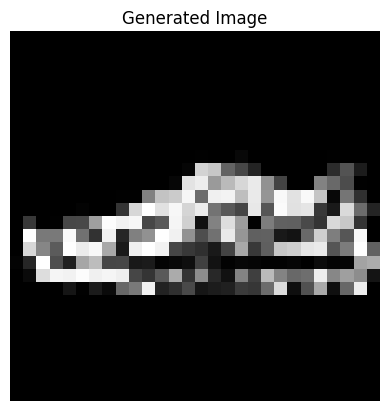

In [4]:
import matplotlib.pyplot as plt
import numpy as np

generator.eval() # Set generator to evaluation mode

# Generate a random noise vector
z = torch.randn(1, latent_dim).to(device)

# Generate an image
with torch.no_grad():
    generated_image = generator(z).cpu()

# Reshape and rescale the image for display
img_np = generated_image.squeeze().numpy() # Remove batch dimension and channel dimension, convert to numpy
img_np = (img_np + 1) / 2.0 # Rescale from [-1, 1] to [0, 1]

# Display the image
plt.imshow(img_np, cmap='gray')
plt.axis('off')
plt.title('Generated Image')
plt.show()